In [244]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [245]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [273]:
main_folder = 'dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000301.jpg'

TRAINING_SAMPLES = 8000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 500
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE=32

In [247]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [248]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling     1
Male        0
Young       0
Mustache    0
Name: 000301.jpg, dtype: int64

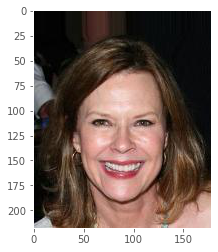

In [249]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young','Mustache']] #some attributes

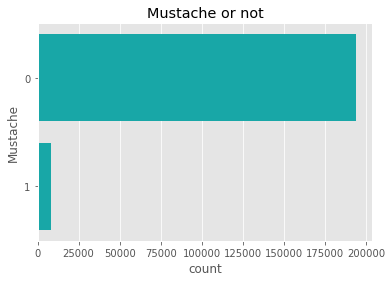

In [250]:
# Female or Male?
plt.title('Mustache or not')
sns.countplot(y='Mustache', data=df_attr, color="c")
plt.show()

In [251]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [252]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [253]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Mustache'], how='inner')
df_par_attr.head()

,partition,Mustache
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,0
000004.jpg,0,0
000005.jpg,0,0


In [254]:
df_par_attr.shape

(202599, 2)

In [255]:
df_par_attr['Mustache'].value_counts().sort_index()

0    194182
1      8417
Name: Mustache, dtype: int64

In [256]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

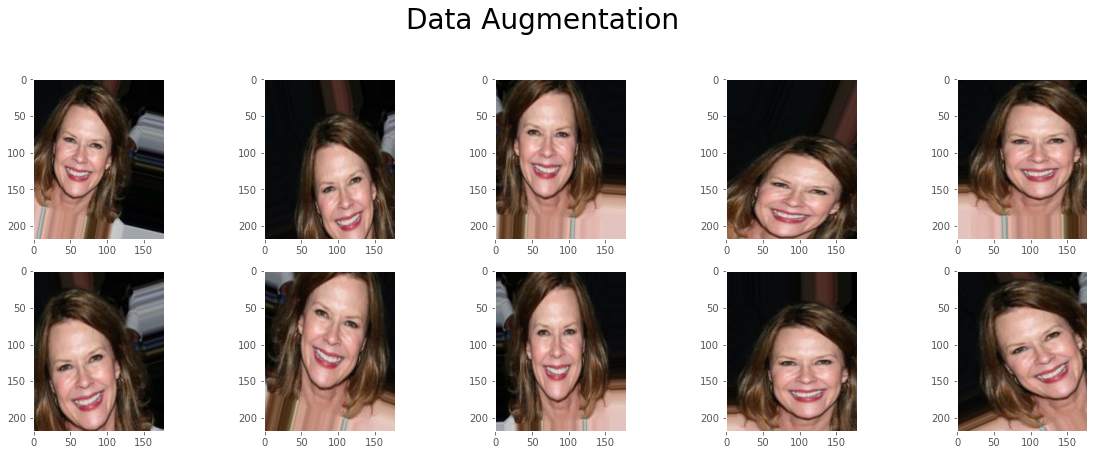

In [257]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [258]:
# Train data
x_train, y_train = generate_df(0, 'Mustache', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=32,
)

In [259]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Mustache', VALIDATION_SAMPLES)

In [260]:
IMG_SIZE = (218, 178)

In [261]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(218, 178, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [262]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [263]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [264]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [265]:
history = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= 30
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.7099 - accuracy: 0.5370
Epoch 00001: val_loss improved from inf to 0.70827, saving model to weights.best.inc.male.hdf5
250/250 [==============================] - 894s 4s/step - loss: 0.7099 - accuracy: 0.5370 - val_loss: 0.7083 - val_accuracy: 0.5140
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.5849
Epoch 00002: val_loss did not improve from 0.70827
250/250 [==============================] - 891s 4s/step - loss: 0.6730 - accuracy: 0.5849 - val_loss: 0.7253 - val_accuracy: 0.5265
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.6200
Epoch 00003: val_loss did not improve from 0.70827
250/250 [==============================] - 892s 4s/step - loss: 0.6454 - accuracy: 0.6200 - val_loss: 0.7092 - val_accuracy: 0.5455
Epoch 4/30
250/250 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.6606
Epoch 00004: val_loss i

Epoch 29/30
250/250 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.8539
Epoch 00029: val_loss did not improve from 0.64758
250/250 [==============================] - 888s 4s/step - loss: 0.3498 - accuracy: 0.8539 - val_loss: 0.6852 - val_accuracy: 0.6080
Epoch 30/30
250/250 [==============================] - ETA: 0s - loss: 0.3446 - accuracy: 0.8543
Epoch 00030: val_loss did not improve from 0.64758
250/250 [==============================] - 890s 4s/step - loss: 0.3446 - accuracy: 0.8543 - val_loss: 0.6805 - val_accuracy: 0.6060


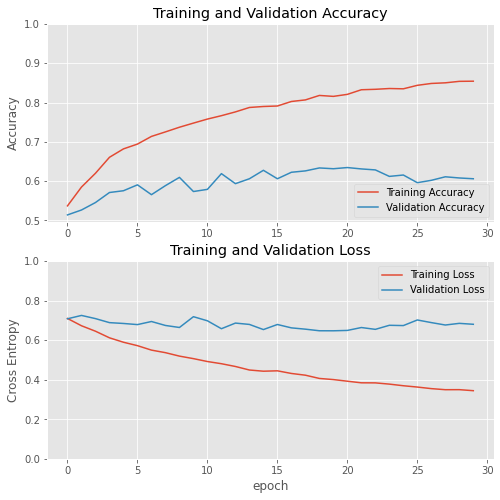

In [266]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [271]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

In [274]:
# Test Data
x_test, y_test = generate_df(2, 'Mustache', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 61.4000%
f1_score: 0.6323809523809524


In [275]:
#save the model
model_.save('my_model.h5')